# Question: What is the difference between the effect of temperature on humidity between the north and the south?


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

plt.rcParams["figure.figsize"] = (25, 20)  # in inches

In [2]:
north_data_in = pd.read_csv("data_north.csv")
south_data_in = pd.read_csv("data_south.csv")

In [3]:
new_column_names = ["station", "date", "temperature", "humidity"]

north_data_in.columns = new_column_names
south_data_in.columns = new_column_names

# Step 1: Drop NaNs
north_data_clean = north_data_in.dropna()
south_data_clean = south_data_in.dropna()

# Step 2: Count how many stations per date in each df
north_data_station_counts = north_data_clean.groupby("date")["station"].nunique()
south_data_station_counts = south_data_clean.groupby("date")["station"].nunique()

# Step 3: Keep only dates where all stations are present
num_stations = north_data_in["station"].nunique()  # same for both
valid_dates_north_data = north_data_station_counts[north_data_station_counts == num_stations].index
valid_dates_south_data = south_data_station_counts[south_data_station_counts == num_stations].index

# Step 4: Find common dates with full data in both dfs
common_full_dates = valid_dates_north_data.intersection(valid_dates_south_data)

# Step 5: Filter both dfs to only common, fully-covered dates
north_data = north_data_clean[north_data_clean["date"].isin(common_full_dates)].copy()
south_data = south_data_clean[south_data_clean["date"].isin(common_full_dates)].copy()

north_data = north_data.reset_index(drop=True)
south_data = south_data.reset_index(drop=True)

north_data["date"] = pd.to_datetime(north_data["date"], format="%d-%m-%Y %H:%M")
south_data["date"] = pd.to_datetime(south_data["date"], format="%d-%m-%Y %H:%M")

display(north_data.head(9))
display(south_data.head(9))

,station,date,temperature,humidity
0,כפר גלעדי 10/2007-07/2025,2020-10-22 06:00:00,19.0,90.0
1,מרום גולן פיכמן 01/1998-07/2025,2020-10-22 06:00:00,6.1,94.0
2,כפר בלום 07/2005-07/2025,2020-10-22 06:00:00,15.4,87.0
3,כפר גלעדי 10/2007-07/2025,2020-10-22 09:00:00,22.5,51.0
4,מרום גולן פיכמן 01/1998-07/2025,2020-10-22 09:00:00,20.2,51.0
5,כפר בלום 07/2005-07/2025,2020-10-22 09:00:00,21.0,68.0
6,כפר גלעדי 10/2007-07/2025,2020-10-22 12:00:00,29.6,36.0
7,מרום גולן פיכמן 01/1998-07/2025,2020-10-22 12:00:00,27.2,24.0
8,כפר בלום 07/2005-07/2025,2020-10-22 12:00:00,30.6,31.0


,station,date,temperature,humidity
0,אשלים 02/2016-07/2025,2020-10-22 06:00:00,16.6,96.0
1,שדה בוקר 01/2004-07/2025,2020-10-22 06:00:00,15.9,92.0
2,עבדת 10/2008-07/2025,2020-10-22 06:00:00,17.3,95.0
3,אשלים 02/2016-07/2025,2020-10-22 09:00:00,21.9,81.0
4,שדה בוקר 01/2004-07/2025,2020-10-22 09:00:00,22.5,73.0
5,עבדת 10/2008-07/2025,2020-10-22 09:00:00,21.0,80.0
6,אשלים 02/2016-07/2025,2020-10-22 12:00:00,28.5,51.0
7,שדה בוקר 01/2004-07/2025,2020-10-22 12:00:00,27.8,49.0
8,עבדת 10/2008-07/2025,2020-10-22 12:00:00,27.3,46.0


### Since there are 3 stations in each dataframe, we will examine the average of the recordings of the 3 stations for each date.

In [4]:
north_avg = north_data.groupby("date")[["temperature", "humidity"]].mean().reset_index().sort_values(by="date")
south_avg = south_data.groupby("date")[["temperature", "humidity"]].mean().reset_index().sort_values(by="date")

display(north_avg.head(3))
display(south_avg.head(3))

,date,temperature,humidity
0,2020-10-22 06:00:00,13.500000,90.333333
1,2020-10-22 09:00:00,21.233333,56.666667
2,2020-10-22 12:00:00,29.133333,30.333333


,date,temperature,humidity
0,2020-10-22 06:00:00,16.600000,94.333333
1,2020-10-22 09:00:00,21.800000,78.000000
2,2020-10-22 12:00:00,27.866667,48.666667


### Comparing between winter and summer will be useful. <br>For our purposes, Summer is May through October and Winter is November through April (both inclusive).

In [5]:
def add_seasonal_background(ax, start_date, end_date):
    """Add seasonal background colors to a matplotlib axis"""
    
    current_date = start_date
    
    while current_date <= end_date:
        year = current_date.year
        month = current_date.month
        
        if 5 <= month <= 10:  # Summer (May-October)
            # Find the end of this summer period
            season_end = min(pd.Timestamp(year, 10, 31), end_date)
            ax.axvspan(current_date, season_end, alpha=0.25, color='yellow', zorder=0)
            current_date = season_end + pd.Timedelta(days=1)
            
        else:  # Winter (November-April)
            if month >= 11:  # November-December
                season_end = min(pd.Timestamp(year, 12, 31), end_date)
            else:  # January-April
                season_end = min(pd.Timestamp(year, 4, 30), end_date)
            
            ax.axvspan(current_date, season_end, alpha=0.25, color='lightblue', zorder=0)
            current_date = season_end + pd.Timedelta(days=1)

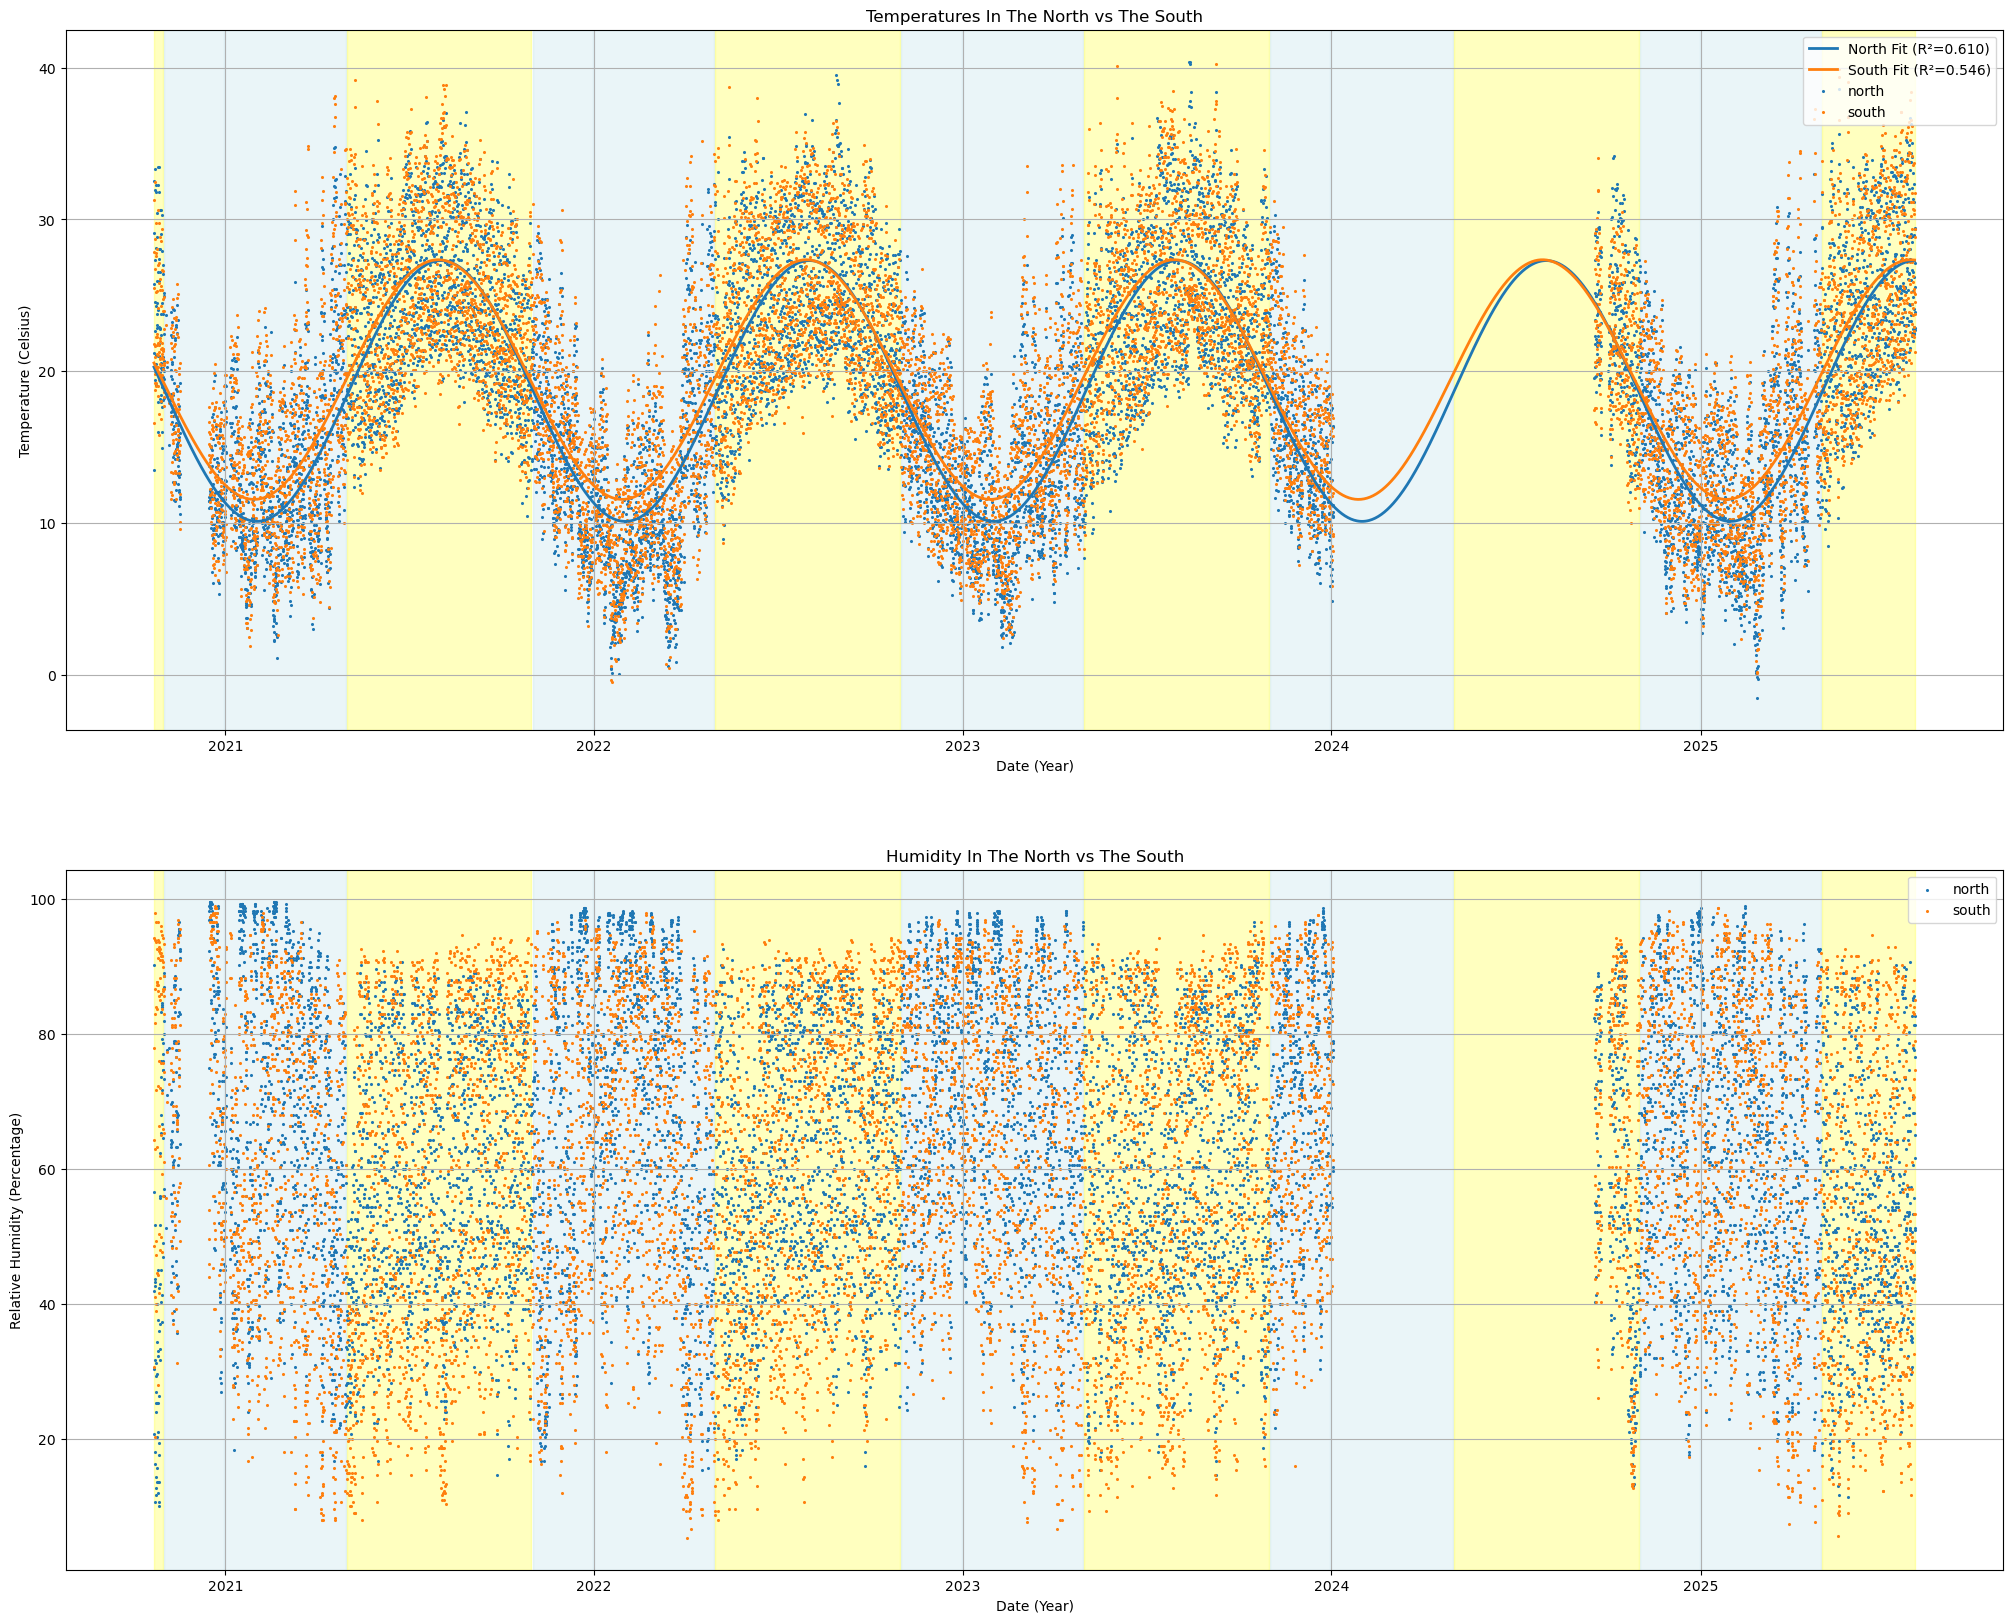

In [37]:
# Define the sine function to fit
def sine_function(x, amplitude, frequency, phase, offset):
    return amplitude * np.sin(frequency * x + phase) + offset

# Convert dates to numeric values for fitting
def fit_sine_to_column(data, date_col='date', temp_col='temperature'):
    # Convert dates to ordinal (days since a reference date)
    data = data.copy().sort_values(date_col)
    x_numeric = data[date_col].map(pd.Timestamp.toordinal)
    y_temp = data[temp_col].values
    
    # Initial parameter guesses
    # amplitude: rough estimate from data range
    amplitude_guess = (y_temp.max() - y_temp.min()) / 2
    # frequency: assuming yearly cycle (365 days)
    frequency_guess = 2 * np.pi / 365.25
    # phase: start of year offset
    phase_guess = 0
    # offset: mean temperature
    offset_guess = y_temp.mean()
    
    initial_guess = [amplitude_guess, frequency_guess, phase_guess, offset_guess]
    
    # Fit the curve
    popt, pcov = curve_fit(sine_function, x_numeric, y_temp, p0=initial_guess)
    
    return popt, x_numeric, y_temp

def calculate_r_squared(y_actual, y_predicted):
    ss_res = np.sum((y_actual - y_predicted) ** 2)
    ss_tot = np.sum((y_actual - np.mean(y_actual)) ** 2)
    return 1 - (ss_res / ss_tot)



# Fit both datasets
north_temp_sin_params, north_x_temps, north_y_temps = fit_sine_to_column(north_avg)
south_temp_sin_params, south_x_temps, south_y_temps = fit_sine_to_column(south_avg)

# Generate smooth curves for plotting
date_range = pd.date_range(start=min(north_avg['date'].min(), south_avg['date'].min()),
                          end=max(north_avg['date'].max(), south_avg['date'].max()),
                          freq='D')
x_smooth = date_range.map(pd.Timestamp.toordinal)

# Calculate fitted curves
north_fitted_temps = sine_function(x_smooth, *north_temp_sin_params)
south_fitted_temps = sine_function(x_smooth, *south_temp_sin_params)



dates = np.array(north_avg["date"])
north_temps = np.array(north_avg["temperature"])
south_temps = np.array(south_avg["temperature"])



fig, ax = plt.subplots(nrows=2, ncols=1)
(temperature_ax, humidity_ax) = ax



# Plot fitted curves
temperature_ax.plot(date_range, north_fitted_temps, color='#1f77b4', linewidth=2, 
        label=f'North Fit (R²={calculate_r_squared(north_y_temps, sine_function(north_x_temps, *north_temp_sin_params)):.3f})')
temperature_ax.plot(date_range, south_fitted_temps, color='#ff7f0e', linewidth=2,
        label=f'South Fit (R²={calculate_r_squared(south_y_temps, sine_function(south_x_temps, *south_temp_sin_params)):.3f})')


temperature_ax.scatter(dates, north_temps, color="#1f77b4", alpha=1, s=1.5, label="north")

temperature_ax.scatter(dates, south_temps, color="#ff7f0e", alpha=1, s=1.5, label="south")


add_seasonal_background(temperature_ax, north_avg["date"][0], north_avg["date"][len(north_avg["date"])-1])



temperature_ax.legend(loc='upper right')
temperature_ax.grid()
temperature_ax.set_title("Temperatures In The North vs The South")
temperature_ax.set_xlabel("Date (Year)")
temperature_ax.set_ylabel("Temperature (Celsius)")




humidity_ax.scatter(north_avg["date"], north_avg["humidity"], alpha=1, s=1.5, label="north")

humidity_ax.scatter(south_avg["date"], south_avg["humidity"], alpha=1, s=1.5, label="south")

add_seasonal_background(humidity_ax, north_avg["date"][0], north_avg["date"][len(north_avg["date"])-1])

humidity_ax.legend(loc='upper right')
humidity_ax.grid()
humidity_ax.set_title("Humidity In The North vs The South")
humidity_ax.set_xlabel("Date (Year)")
humidity_ax.set_ylabel("Relative Humidity (Percentage)")


plt.show()